In [1]:
# imports
from pyimagesearch.learningratefinder import LearningRateFinder
from pyimagesearch.clr_callback import CyclicLR
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from wandb.keras import WandbCallback
from pyimagesearch import config
from utils import data_utils
import tensorflow as tf
import numpy as np
import wandb
import time

The `pyimagesearch` module comes from our tutorial [Keras Learning Rate Finder](https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/). 

In [2]:
# fix random seed for better reproducibility
tf.random.set_seed(666)

In [3]:
# don't change this
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

In [4]:
# define the constants
BATCH_SIZE = 64
EPOCHS = 20

In [5]:
# let's load up the tfrecord filenames
tfr_pattern_train = "train_tfr/*.tfrec"
train_filenames = tf.io.gfile.glob(tfr_pattern_train)
tfr_pattern_test = "test_tfr/*.tfrec"
test_filenames = tf.io.gfile.glob(tfr_pattern_test)

In [6]:
# create the train and test dataset
training_dataset, steps_per_epoch = data_utils.batch_dataset(train_filenames, BATCH_SIZE, True)
validation_dataset, validation_steps = data_utils.batch_dataset(test_filenames, BATCH_SIZE, False)

In [7]:
# create a utility function to define our model
def create_model(img_size=(224,224), num_class=5, train_base=True):
    input_layer = Input(shape=(img_size[0],img_size[1],3))
    base = VGG16(input_tensor=input_layer,
                    include_top=False,
                    weights="imagenet")
    base.trainable = train_base
    x = base.output
    x = GlobalAveragePooling2D()(x)
    
    preds = Dense(num_class, activation="softmax")(x)
    return Model(inputs=input_layer, outputs=preds)

In [8]:
# instantiate the model, supply the loss scaled optimizer,
# and compile it
model = create_model()
opt = Adam(learning_rate=config.MIN_LR)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

**Brief steps to find a learning rate range**:

![](https://i.ibb.co/J3LjtNS/Screen-Shot-2019-12-08-at-9-55-29-AM.png)

<center><a href="https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/">Credits</a></center>

In [9]:
# use the learning rate finder to find a suitable range 
# to train our network
lrf = LearningRateFinder(model)
lrf.find(
    training_dataset,
    1e-10, 1e+1,
    stepsPerEpoch=steps_per_epoch,
    batchSize=config.BATCH_SIZE)

Epoch 1/43
48/48 [==============================] - 77s 2s/step - loss: 1.9289 - accuracy: 0.2122
Epoch 2/43
48/48 [==============================] - 62s 1s/step - loss: 1.9036 - accuracy: 0.2214
Epoch 3/43
48/48 [==============================] - 62s 1s/step - loss: 1.9275 - accuracy: 0.2116
Epoch 4/43
48/48 [==============================] - 62s 1s/step - loss: 1.9264 - accuracy: 0.2135
Epoch 5/43
48/48 [==============================] - 62s 1s/step - loss: 1.9091 - accuracy: 0.2194
Epoch 6/43
48/48 [==============================] - 62s 1s/step - loss: 1.9201 - accuracy: 0.2152
Epoch 7/43
48/48 [==============================] - 62s 1s/step - loss: 1.9227 - accuracy: 0.2109
Epoch 8/43
48/48 [==============================] - 62s 1s/step - loss: 1.9090 - accuracy: 0.2210
Epoch 9/43
48/48 [==============================] - 62s 1s/step - loss: 1.9116 - accuracy: 0.2129
Epoch 10/43
48/48 [==============================] - 62s 1s/step - loss: 1.9018 - accuracy: 0.2178
Epoch 11/43
48/48 [

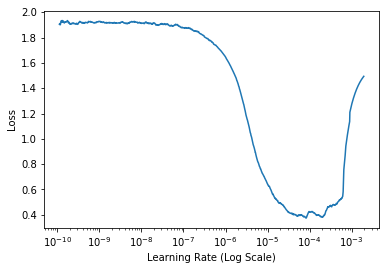

In [10]:
# let's plot the learning rates
lrf.plot_loss()

In [11]:
# initialize wandb
wandb.init("ml-bootcamp")

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/sayakpaul/ML-Bootcamp-Launchpad/runs/1pejp8xz

In [12]:
# instantiate the model, supply the loss scaled optimizer,
# and compile it
model = create_model()
opt = Adam(learning_rate=config.MIN_LR)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [13]:
# compute the step size and initialize the cyclic learning
# rate method
step_size = config.STEP_SIZE * steps_per_epoch
clr = CyclicLR(
	mode=config.CLR_METHOD,
	base_lr=1e-6,
	max_lr=1e-5,
	step_size=step_size)

In [14]:
# train the network with CLR
start = time.time()
model.fit_generator(training_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[clr, WandbCallback(data_type="image", labels=CLASSES)])
wandb.log({"training_time": time.time() - start})

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Epoch 1/20
48/48 [==============================] - 73s 2s/step - loss: 1.6296 - accuracy: 0.2933 - val_loss: 1.4477 - val_accuracy: 0.4434
Epoch 2/20
48/48 [==============================] - 67s 1s/step - loss: 1.3129 - accuracy: 0.5085 - val_loss: 1.0919 - val_accuracy: 0.6719
Epoch 3/20
48/48 [==============================] - 68s 1s/step - loss: 0.9036 - accuracy: 0.6742 - val_loss: 0.5805 - val_accuracy: 0.7812
Epoch 4/20
48/48 [==============================] - 68s 1s/step - loss: 0.6019 - accuracy: 0.7835 - val_loss: 0.4196 - val_accuracy: 0.8555
Epoch 5/20
48/48 [==============================] - 68s 1s/step - loss: 0.4844 - accuracy: 0.8301 - val_loss: 0.3418 - val_accuracy: 0.8887
Epoch 6/20
48/48 [==============================] - 68s 1s/step - loss: 0.4226 - accuracy: 0.8512 - val_loss: 0.2808 - val_accuracy: 0.9043
Epoch 7/20
48/48 [==============================] - 68s 1s/step - loss: 0.3542 - accuracy: 0.8714 - val_loss: 0.2663 - val_accuracy: 0.9023
Epoch 8/20
48/48 [==